<a href="https://colab.research.google.com/github/merkelmauer/mirna/blob/main/Initial_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo

In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/master')

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.distributions as dist
from torchinfo import summary

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder

#from model_diva import DIVA

ModuleNotFoundError: ignored

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class diva_args:

    def __init__(self, zd_dim=32, zx_dim=32, zy_dim=32, d_dim=45, x_dim=7500, 
                 y_dim=2, aux_loss_multiplier_y=3500, aux_loss_multiplier_d=2000,
                 beta_d=1, beta_x=1, beta_y=1):

        self.zd_dim = zd_dim
        self.zx_dim = zx_dim
        self.zy_dim = zy_dim
        self.d_dim = d_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.aux_loss_multiplier_y = aux_loss_multiplier_y
        self.aux_loss_multiplier_d = aux_loss_multiplier_d
        self.beta_d = beta_d
        self.beta_x = beta_x
        self.beta_y = beta_y


In [ ]:
class MicroRNADataset(Dataset):

    def __init__(self, cat_data=True):
        
        # loading images
        
        if not cat_data:
            print('Loading and Converting Images! (~90min)')
            images = np.load('/content/drive/MyDrive/master/modmirbase_train_images.npz')['arr_0']/255
            self.images = self.im2col(images)
        else:
            print('Loading Converted Images (~1min)')
            self.images = np.load('/content/drive/MyDrive/master/modmirbase_train_images_wbrgby.npz')#['arr_0']
        
        
        # loading labels
        print('Loading Labels! (~10s)')     
        ohe = OneHotEncoder(categories='auto', sparse=False)
        labels = np.load('/content/drive/MyDrive/master/modmirbase_train_labels.npz')['arr_0']
        self.labels = ohe.fit_transform(labels)
        
        
        # loading names
        print('Loading Names! (~5s)')
        names =  np.load('/content/drive/MyDrive/master/modmirbase_train_names.npz')['arr_0']
        names = [i.decode('utf-8') for i in names]
        self.species = ['mmu', 'prd', 'hsa', 'ptr', 'efu', 'cbn', 'gma', 'pma',
                        'cel', 'gga', 'ipu', 'ptc', 'mdo', 'cgr', 'bta', 'cin', 
                        'ppy', 'ssc', 'ath', 'cfa', 'osa', 'mtr', 'gra', 'mml',
                        'stu', 'bdi', 'rno', 'oan', 'dre', 'aca', 'eca', 'chi',
                        'bmo', 'ggo', 'aly', 'dps', 'mdm', 'ame', 'ppc', 'ssa',
                        'ppt', 'tca', 'dme', 'sbi']
        # assigning a species label to each observation from species
        # with more than 200 observations from past research
        self.names = []
        for i in names:
            append = False
            for j in self.species:
                if j in i.lower():
                    self.names.append(j)
                    append = True
                    break
            if not append:
                if 'random' in i.lower() or i.isdigit():
                    self.names.append('hsa')
                else:
                    self.names.append('notfound')
        
        # performing one hot encoding
        ohe = OneHotEncoder(categories='auto', sparse=False)
        self.names_ohe = ohe.fit_transform(np.array(self.names).reshape(-1,1))
      
    def __len__(self):
        return(self.images.shape[0])

    def __getitem__(self, idx):
        d = self.names_ohe[idx]
        y = self.labels[idx]
        x = self.images[idx]
        x = np.transpose(x, (2,0,1))
        return (x, y, d)

    def im2col(self, images):
        """
        One hot encodes images
        0: black
        1: white
        2: red
        3: green
        4: blue
        5: yellow
        """
        out_shape = (images.shape[0],images.shape[1],images.shape[2],6)
        out_array = np.zeros(out_shape)
        for i in range(out_array.shape[0]):
            print(f'at image {i} out of {out_array.shape[0]}!')
            for j in range(out_array.shape[1]):
                for k in range(out_array.shape[2]):
                    #print(images[i,j,k].shape, images[i,j,k])
                    curr = images[i,j,k]
                    if (curr==np.array([0,0,0])).all():
                        out_array[i,j,k,0] = 1
                    elif (curr==np.array([1,1,1])).all():
                        out_array[i,j,k,1] = 1
                    elif (curr==np.array([1,0,0])).all():
                        out_array[i,j,k,2] = 1
                    elif (curr==np.array([0,1,0])).all():
                        out_array[i,j,k,3] = 1
                    elif (curr==np.array([0,0,1])).all():
                        out_array[i,j,k,4] = 1
                    elif (curr==np.array([1,1,0])).all():
                        out_array[i,j,k,5] = 1
                    else:
                        print("big error!!!")
        print('saving new file!')
        with open('/content/drive/MyDrive/master/modmirbase_train_images_wbrgby.npz', 'wb') as f:
            np.save(f, out_array)
        return out_array
                    
                    

In [ ]:
RNA_dataset = MicroRNADataset()

Loading Converted Images (~1min)


FileNotFoundError: ignored

In [ ]:
len(RNA_dataset)

34721

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
# names =  np.load('/content/drive/MyDrive/master/modmirbase_train_names.npz')['arr_0']
# labels = np.load('/content/drive/MyDrive/master/modmirbase_train_labels.npz')['arr_0']
# images = np.load('/content/drive/MyDrive/master/modmirbase_train_images.npz')['arr_0']

In [ ]:
# Decoders
class px(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(px, self).__init__()

        self.fc1 = nn.Sequential(nn.Linear(zd_dim + zx_dim + zy_dim, 2048, bias=False), 
                                 nn.BatchNorm1d(2048), 
                                 nn.ReLU())
        self.up1 = nn.Upsample(scale_factor=5)
        self.de1 = nn.Sequential(nn.ConvTranspose2d(512, 256, kernel_size=5, stride=1, padding=2, bias=False), 
                                 nn.BatchNorm2d(256),
                                 nn.ReLU(),
                                 nn.Conv2d(256,256, kernel_size=3, padding='same', stride=1)
                                 nn.BatchNorm2d(256),
                                 nn.ReLU()
                                 )
        self.up2 = nn.Upsample(scale_factor=5)
        self.de2 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False), 
                                 nn.BatchNorm2d(128), 
                                 nn.ReLU()),
                                 nn.Conv2d(128,128, kernel_size=3, padding='same', stride=1)
                                 nn.BatchNorm2d(128),
                                 nn.ReLU()
        self.de3 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding='same', stride=1),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(),
                                 nn.Conv2d(64, 6, kernel_size=1, padding='same'),
                                 nn.Softmax(dim=1))

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.de1[0].weight)
        torch.nn.init.xavier_uniform_(self.de2[0].weight)
        torch.nn.init.xavier_uniform_(self.de3[0].weight)
        self.de3[0].bias.data.zero_()

    def forward(self, zd, zx, zy):
        if zx is None:
            zdzxzy = torch.cat((zd, zy), dim=-1)
        else:
            zdzxzy = torch.cat((zd, zx, zy), dim=-1)
        h = self.fc1(zdzxzy)
        h = h.view(-1, 512, 1, 4)
        h = self.up1(h)
        h = self.de1(h)
        h = self.up2(h)
        h = self.de2(h)
        loc_img = self.de3(h)

        return loc_img


class pzd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(pzd, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(d_dim, zd_dim, bias=False), 
                                 nn.BatchNorm1d(zd_dim), 
                                 nn.ReLU())
        self.fc21 = nn.Sequential(nn.Linear(zd_dim, zd_dim))
        self.fc22 = nn.Sequential(nn.Linear(zd_dim, zd_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.fc21[0].weight)
        self.fc21[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc22[0].weight)
        self.fc22[0].bias.data.zero_()

    def forward(self, d):
        hidden = self.fc1(d)
        zd_loc = self.fc21(hidden)
        zd_scale = self.fc22(hidden) + 1e-7

        return zd_loc, zd_scale


class pzy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(pzy, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(y_dim, zy_dim, bias=False),
                                 nn.BatchNorm1d(zy_dim), 
                                 nn.ReLU())
        self.fc21 = nn.Sequential(nn.Linear(zy_dim, zy_dim))
        self.fc22 = nn.Sequential(nn.Linear(zy_dim, zy_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.fc1[0].weight)
        torch.nn.init.xavier_uniform_(self.fc21[0].weight)
        self.fc21[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc22[0].weight)
        self.fc22[0].bias.data.zero_()

    def forward(self, y):
        hidden = self.fc1(y)
        zy_loc = self.fc21(hidden)
        zy_scale = self.fc22(hidden) + 1e-7

        return zy_loc, zy_scale

In [ ]:
pzy_ = pzy(45, 7500, 2, 32,32,32)
summary(pzy_, (1,2))

Layer (type:depth-idx)                   Output Shape              Param #
pzy                                      --                        --
├─Sequential: 1-1                        [1, 32]                   --
│    └─Linear: 2-1                       [1, 32]                   64
│    └─BatchNorm1d: 2-2                  [1, 32]                   64
│    └─ReLU: 2-3                         [1, 32]                   --
├─Sequential: 1-2                        [1, 32]                   --
│    └─Linear: 2-4                       [1, 32]                   1,056
├─Sequential: 1-3                        [1, 32]                   --
│    └─Linear: 2-5                       [1, 32]                   1,056
│    └─Softplus: 2-6                     [1, 32]                   --
Total params: 2,240
Trainable params: 2,240
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [ ]:
class qzd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzd, self).__init__()

        self.encoder = nn.Sequential(
            # block 1
            nn.Conv2d(6, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc11 = nn.Sequential(nn.Linear(4608, zd_dim))
        self.fc12 = nn.Sequential(nn.Linear(4608, zd_dim), nn.Softplus())
        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.encoder[7].weight)
        torch.nn.init.xavier_uniform_(self.encoder[10].weight)
        torch.nn.init.xavier_uniform_(self.encoder[14].weight)
        torch.nn.init.xavier_uniform_(self.encoder[17].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4608)
        zd_loc = self.fc11(h)
        zd_scale = self.fc12(h) + 1e-7

        return zd_loc, zd_scale


class qzx(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzx, self).__init__()

        self.encoder = nn.Sequential(
            # block 1
            nn.Conv2d(6, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc11 = nn.Sequential(nn.Linear(4608, zx_dim))
        self.fc12 = nn.Sequential(nn.Linear(4608, zx_dim), nn.Softplus())

        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[3].weight)
        torch.nn.init.xavier_uniform_(self.encoder[7].weight)
        torch.nn.init.xavier_uniform_(self.encoder[10].weight)
        torch.nn.init.xavier_uniform_(self.encoder[14].weight)
        torch.nn.init.xavier_uniform_(self.encoder[17].weight)
        torch.nn.init.xavier_uniform_(self.fc11[0].weight)
        self.fc11[0].bias.data.zero_()
        torch.nn.init.xavier_uniform_(self.fc12[0].weight)
        self.fc12[0].bias.data.zero_()

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4608)
        zx_loc = self.fc11(h)
        zx_scale = self.fc12(h) + 1e-7

        return zx_loc, zx_scale


class qzy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qzy, self).__init__()

        self.encoder = nn.Sequential(
            # block 1
            nn.Conv2d(6, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, bias=False, padding='same'), 
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc11 = nn.Sequential(nn.Linear(4608, zy_dim))
        self.fc12 = nn.Sequential(nn.Linear(4608, zy_dim), nn.Softplus())

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(-1, 4608)
        zy_loc = self.fc11(h)
        zy_scale = self.fc12(h) + 1e-7

        return zy_loc, zy_scale

In [ ]:
# Auxiliary tasks
class qd(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qd, self).__init__()

        self.fc1 = nn.Linear(zd_dim, d_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zd):
        h = F.relu(zd)
        loc_d = self.fc1(h)

        return loc_d


class qy(nn.Module):
    def __init__(self, d_dim, x_dim, y_dim, zd_dim, zx_dim, zy_dim):
        super(qy, self).__init__()

        self.fc1 = nn.Linear(zy_dim, y_dim)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.zero_()

    def forward(self, zy):
        h = F.relu(zy)
        loc_y = self.fc1(h)

        return loc_y

In [ ]:
class DIVA(nn.Module):
    def __init__(self, args):
        super(DIVA, self).__init__()
        self.zd_dim = args.zd_dim
        self.zx_dim = args.zx_dim
        self.zy_dim = args.zy_dim
        self.d_dim = args.d_dim
        self.x_dim = args.x_dim
        self.y_dim = args.y_dim

        self.start_zx = self.zd_dim
        self.start_zy = self.zd_dim + self.zx_dim

        self.px = px(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.pzd = pzd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.pzy = pzy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.qzd = qzd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        if self.zx_dim != 0:
            self.qzx = qzx(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.qzy = qzy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.qd = qd(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)
        self.qy = qy(self.d_dim, self.x_dim, self.y_dim, self.zd_dim, self.zx_dim, self.zy_dim)

        self.aux_loss_multiplier_y = args.aux_loss_multiplier_y
        self.aux_loss_multiplier_d = args.aux_loss_multiplier_d

        self.beta_d = args.beta_d
        self.beta_x = args.beta_x
        self.beta_y = args.beta_y

        self.cuda()

    def forward(self, d, x, y):
        # Encode
        zd_q_loc, zd_q_scale = self.qzd(x)
        if self.zx_dim != 0:
            zx_q_loc, zx_q_scale = self.qzx(x)
        zy_q_loc, zy_q_scale = self.qzy(x)

        # Reparameterization trick
        qzd = dist.Normal(zd_q_loc, zd_q_scale)
        zd_q = qzd.rsample()
        if self.zx_dim != 0:
            qzx = dist.Normal(zx_q_loc, zx_q_scale)
            zx_q = qzx.rsample()
        else:
            qzx = None
            zx_q = None

        qzy = dist.Normal(zy_q_loc, zy_q_scale)
        zy_q = qzy.rsample()

        # Decode
        x_recon = self.px(zd_q, zx_q, zy_q)

        zd_p_loc, zd_p_scale = self.pzd(d)

        if self.zx_dim != 0:
            zx_p_loc, zx_p_scale = torch.zeros(zd_p_loc.size()[0], self.zx_dim).cuda(),\
                                   torch.ones(zd_p_loc.size()[0], self.zx_dim).cuda()
        zy_p_loc, zy_p_scale = self.pzy(y)

        # Reparameterization trick
        pzd = dist.Normal(zd_p_loc, zd_p_scale)
        if self.zx_dim != 0:
            pzx = dist.Normal(zx_p_loc, zx_p_scale)
        else:
            pzx = None
        pzy = dist.Normal(zy_p_loc, zy_p_scale)

        # Auxiliary losses
        d_hat = self.qd(zd_q)
        y_hat = self.qy(zy_q)

        return x_recon, d_hat, y_hat, qzd, pzd, zd_q, qzx, pzx, zx_q, qzy, pzy, zy_q

    def loss_function(self, d, x, y=None):
        if y is None:  # unsupervised
            # Do standard forward pass for everything not involving y
            zd_q_loc, zd_q_scale = self.qzd(x)
            if self.zx_dim != 0:
                zx_q_loc, zx_q_scale = self.qzx(x)
            zy_q_loc, zy_q_scale = self.qzy(x)

            qzd = dist.Normal(zd_q_loc, zd_q_scale)
            zd_q = qzd.rsample()
            if self.zx_dim != 0:
                qzx = dist.Normal(zx_q_loc, zx_q_scale)
                zx_q = qzx.rsample()
            else:
                zx_q = None
            qzy = dist.Normal(zy_q_loc, zy_q_scale)
            zy_q = qzy.rsample()

            zd_p_loc, zd_p_scale = self.pzd(d)
            if self.zx_dim != 0:
                zx_p_loc, zx_p_scale = torch.zeros(zd_p_loc.size()[0], self.zx_dim).cuda(), \
                                       torch.ones(zd_p_loc.size()[0], self.zx_dim).cuda()

            pzd = dist.Normal(zd_p_loc, zd_p_scale)

            if self.zx_dim != 0:
                pzx = dist.Normal(zx_p_loc, zx_p_scale)
            else:
                pzx = None

            d_hat = self.qd(zd_q)

            x_recon = self.px(zd_q, zx_q, zy_q)

            x_recon = x_recon.view(-1, 256)
            x_target = (x.view(-1) * 255).long()
            CE_x = F.cross_entropy(x_recon, x_target, reduction='sum')

            zd_p_minus_zd_q = torch.sum(pzd.log_prob(zd_q) - qzd.log_prob(zd_q))
            if self.zx_dim != 0:
                KL_zx = torch.sum(pzx.log_prob(zx_q) - qzx.log_prob(zx_q))
            else:
                KL_zx = 0

            _, d_target = d.max(dim=1)
            CE_d = F.cross_entropy(d_hat, d_target, reduction='sum')


            # Create labels and repeats of zy_q and qzy
            y_onehot = torch.eye(10)
            y_onehot = y_onehot.repeat(1, 100)
            y_onehot = y_onehot.view(1000, 10).cuda()

            zy_q = zy_q.repeat(10, 1)
            zy_q_loc, zy_q_scale = zy_q_loc.repeat(10, 1), zy_q_scale.repeat(10, 1)
            qzy = dist.Normal(zy_q_loc, zy_q_scale)

            # Do forward pass for everything involving y
            zy_p_loc, zy_p_scale = self.pzy(y_onehot)

            # Reparameterization trick
            pzy = dist.Normal(zy_p_loc, zy_p_scale)

            # Auxiliary losses
            y_hat = self.qy(zy_q)

            # Marginals
            alpha_y = F.softmax(y_hat, dim=-1)
            qy = dist.OneHotCategorical(alpha_y)
            prob_qy = torch.exp(qy.log_prob(y_onehot))

            zy_p_minus_zy_q = torch.sum(pzy.log_prob(zy_q) - qzy.log_prob(zy_q), dim=-1)

            marginal_zy_p_minus_zy_q = torch.sum(prob_qy * zy_p_minus_zy_q)

            prior_y = torch.tensor(1/10).cuda()
            prior_y_minus_qy = torch.log(prior_y) - qy.log_prob(y_onehot)
            marginal_prior_y_minus_qy = torch.sum(prob_qy * prior_y_minus_qy)

            return CE_x \
                   - self.beta_d * zd_p_minus_zd_q \
                   - self.beta_x * KL_zx \
                   - self.beta_y * marginal_zy_p_minus_zy_q \
                   - marginal_prior_y_minus_qy \
                   + self.aux_loss_multiplier_d * CE_d

        else: # supervised
            x_recon, d_hat, y_hat, qzd, pzd, zd_q, qzx, pzx, zx_q, qzy, pzy, zy_q = self.forward(d, x, y)
            #print(x_recon.shape, x.shape)
            #x_recon = x_recon.view(-1, 256)
            #x_target = (x.view(-1) * 255).long()

            #CE_x = -log_mix_dep_Logistic_256(x, x_recon, average=False, n_comps=10)
            x_recon = x_recon.view(-1,6)
            x_target = x.view(-1,6)
            CE_x = F.cross_entropy(x_recon, x_target, reduction='sum')
            
            zd_p_minus_zd_q = torch.sum(pzd.log_prob(zd_q) - qzd.log_prob(zd_q))
            if self.zx_dim != 0:
                KL_zx = torch.sum(pzx.log_prob(zx_q) - qzx.log_prob(zx_q))
            else:
                KL_zx = 0

            zy_p_minus_zy_q = torch.sum(pzy.log_prob(zy_q) - qzy.log_prob(zy_q))

            _, d_target = d.max(dim=1)
            CE_d = F.cross_entropy(d_hat, d_target, reduction='sum')

            _, y_target = y.max(dim=1)
            CE_y = F.cross_entropy(y_hat, y_target, reduction='sum')

            return CE_x \
                   - self.beta_d * zd_p_minus_zd_q \
                   - self.beta_x * KL_zx \
                   - self.beta_y * zy_p_minus_zy_q \
                   + self.aux_loss_multiplier_d * CE_d \
                   + self.aux_loss_multiplier_y * CE_y,\
                   CE_y

    def classifier(self, x):
        """
        classify an image (or a batch of images)
        :param xs: a batch of scaled vectors of pixels from an image
        :return: a batch of the corresponding class labels (as one-hots)
        """
        with torch.no_grad():
            zd_q_loc, zd_q_scale = self.qzd(x)
            zd = zd_q_loc
            alpha = F.softmax(self.qd(zd), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            d = x.new_zeros(alpha.size())
            d = d.scatter_(1, ind, 1.0)

            zy_q_loc, zy_q_scale = self.qzy.forward(x)
            zy = zy_q_loc
            alpha = F.softmax(self.qy(zy), dim=1)

            # get the index (digit) that corresponds to
            # the maximum predicted class probability
            res, ind = torch.topk(alpha, 1)

            # convert the digit(s) to one-hot tensor(s)
            y = x.new_zeros(alpha.size())
            y = y.scatter_(1, ind, 1.0)

        return d, y

In [ ]:
default_args = diva_args()

In [ ]:
diva = DIVA(default_args).to(DEVICE)

In [ ]:
#summary(diva, [(1,45),(1,6,25,100),(1,2)])

In [ ]:
def train_single_epoch(train_loader, model, optimizer):
    model.train()
    train_loss = 0
    epoch_class_y_loss = 0

    no_batches = 0

    for batch_idx, (x, y, d) in enumerate(train_loader):
        # To device
        # print(x)
        # print(y)
        # print(d)
        x, y, d = x.to(DEVICE), y.to(DEVICE), d.to(DEVICE)

        # if (epoch % 50 == 0) and (batch_idx == 1):
        #     save_reconstructions(model, d, x, y)

        optimizer.zero_grad()
        loss, class_y_loss = model.loss_function(d.float(), x.float(), y.float())
        loss.backward()
        optimizer.step()

        train_loss += loss
        epoch_class_y_loss += class_y_loss
        no_batches += 1
        print(f'finished batch {no_batches}!')
        if no_batches == 25:
            break

    train_loss /= len(train_loader.dataset)
    epoch_class_y_loss /= len(train_loader.dataset)

    return train_loss, epoch_class_y_loss

In [ ]:
train_loader = DataLoader(RNA_dataset, batch_size=256, shuffle=True)

In [ ]:
optimizer = optim.Adam(diva.parameters(), lr=0.001)

In [ ]:
epoch_loss_sup = []
epoch_loss_y = []
for epoch in range(1, 11):
    avg_epoch_losses_sup, avg_epoch_class_y_loss = train_single_epoch(train_loader, diva, optimizer)
    str_loss_sup = avg_epoch_losses_sup
    epoch_loss_sup.append(avg_epoch_losses_sup)
    epoch_loss_y.append(avg_epoch_class_y_loss)
    str_print = "{} epoch: avg loss {}".format(epoch, str_loss_sup)
    str_print += ", class y loss {}".format(avg_epoch_class_y_loss)
    print(str_print)

finished batch 1!
finished batch 2!
finished batch 3!
finished batch 4!
finished batch 5!
finished batch 6!
finished batch 7!
finished batch 8!
finished batch 9!
finished batch 10!
finished batch 11!
finished batch 12!
finished batch 13!
finished batch 14!
finished batch 15!
finished batch 16!
finished batch 17!
finished batch 18!
finished batch 19!
finished batch 20!
finished batch 21!
finished batch 22!
finished batch 23!
finished batch 24!
finished batch 25!
1 epoch: avg loss 2294.816162109375, class y loss 0.12217766046524048
finished batch 1!
finished batch 2!
finished batch 3!
finished batch 4!
finished batch 5!
finished batch 6!
finished batch 7!
finished batch 8!
finished batch 9!
finished batch 10!
finished batch 11!
finished batch 12!
finished batch 13!
finished batch 14!
finished batch 15!
finished batch 16!
finished batch 17!
finished batch 18!
finished batch 19!
finished batch 20!
finished batch 21!
finished batch 22!
finished batch 23!
finished batch 24!
finished batch 25

In [ ]:
torch.save(diva.state_dict, '/content/drive/MyDrive/master/diva_v1.pth')

In [ ]:
def sample(x):
    """
    takes sample for each pixel given probabilities
    input: reconstructed x (shape: -1,6,25,100)
    output: sample from x (shape: -1,25,100,3)
    """
    color_dict = {1: np.array([1,1,1]), # white
                  0: np.array([0,0,0]), # black
                  2: np.array([1,0,0]), # red
                  3: np.array([0,1,0]), # green
                  4: np.array([0,0,1]), # blue
                  5: np.array([1,1,0])  # yellow
                  }
    out = np.zeros((x.shape[0],x.shape[2],x.shape[3], 3))
    for i in range(x.shape[0]):
      for j in range(x.shape[2]):
        for k in range(x.shape[3]):
          p = x[i,:,j,k]
          p = p.astype(np.float64)
          p += 1e-7
          #print(p)
          p /= p.sum()
          #print(p, sum(p))
          pix = np.random.choice(np.arange(6), p=p)
          out[i,j,k] = color_dict[pix]
    return out

In [ ]:
def decode(x):
    """
    gives image in pixels given x
    input: training x (shape: -1,6,25,100)
    output:  x (shape: -1,25,100,3)
    """
    color_dict = {1: np.array([1,1,1]), # white
              0: np.array([0,0,0]), # black
              2: np.array([1,0,0]), # red
              3: np.array([0,1,0]), # green
              4: np.array([0,0,1]), # blue
              5: np.array([1,1,0])  # yellow
              }
    out = np.zeros((x.shape[0],x.shape[2],x.shape[3], 3))
    for i in range(x.shape[0]):
      for j in range(x.shape[2]):
        for k in range(x.shape[3]):
          for l in range(6):
            if x[i,l,j,k] == 1:
              out[i,j,k] = color_dict[l]
    return out

In [ ]:
a = next(enumerate(train_loader))

In [ ]:
[h.shape for h in a[1]]

[torch.Size([256, 6, 25, 100]), torch.Size([256, 2]), torch.Size([256, 45])]

In [ ]:
with torch.no_grad():
    diva.eval()
    d = a[1][2][:9].to(DEVICE).float()
    x = a[1][0][:9].to(DEVICE).float()
    y = a[1][1][:9].to(DEVICE).float()
    x_recon, d_hat, y_hat, qzd, pzd, zd_q, qzx, pzx, zx_q, qzy, pzy, zy_q = diva(d,x,y)
    sample_x = sample(x_recon.cpu().numpy())

<Figure size 3600x3600 with 0 Axes>

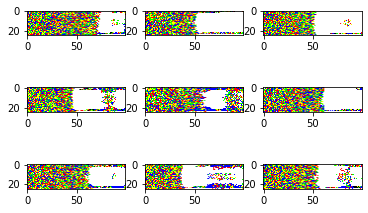

In [ ]:
plt.figure(figsize=(50,50))
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(sample_x[i])

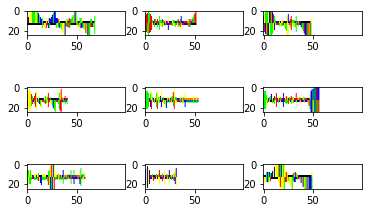

In [ ]:
x_true = decode(x)
fig, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
  ax[i//3, i%3].imshow(x_true[i])